In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE

import warnings 

warnings.simplefilter("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [3]:

'''
Before cluster classification, average u_in that correlates
with the constant objective variable of the time stamp by each breath_id.
'''

def class_time_step(x):
    if x < 1.0:
        return 0
    elif x < 1.5:
        return 1
    else:
        return 2
    
train["log_u_in"] = np.log1p(train.u_in)
test["log_u_in"] = np.log1p(test.u_in)

train["time_step_class"] = train.time_step.apply(class_time_step)
test["time_step_class"] = test.time_step.apply(class_time_step)

piv = train.pivot_table(index="breath_id", columns="time_step_class", values="log_u_in", fill_value=0, aggfunc="mean")
piv_test = test.pivot_table(index="breath_id", columns="time_step_class", values="log_u_in", fill_value=0, aggfunc="mean")

piv.head()

time_step_class,0,1,2
breath_id,,,
1,3.054744,0.000000,1.623373
2,2.183309,0.027139,1.646916
3,2.261596,0.000000,1.555113
4,2.282772,0.000000,1.565501
5,3.238464,0.010017,1.638008


# PCA 

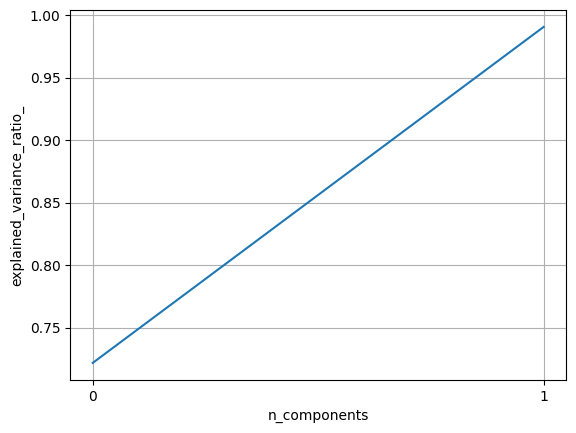

In [4]:
pca = PCA(n_components=2, random_state=42)
pca.fit(piv)

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.grid()
plt.xlabel("n_components")
plt.ylabel("explained_variance_ratio_")
plt.xticks([0, 1])
plt.show()

In [5]:
train_pca = pca.transform(piv)
test_pca = pca.transform(piv_test)

train_pca = pd.DataFrame(train_pca, columns=["c"+str(c) for c in range(2)], index=piv.index)
test_pca = pd.DataFrame(test_pca, columns=["c"+str(c) for c in range(2)], index=piv_test.index)

train_pca.head()

,c0,c1
breath_id,,
1,1.073702,-0.015488
2,0.208490,-0.112946
3,0.282629,-0.092003
4,0.304355,-0.093277
5,1.255746,0.011834


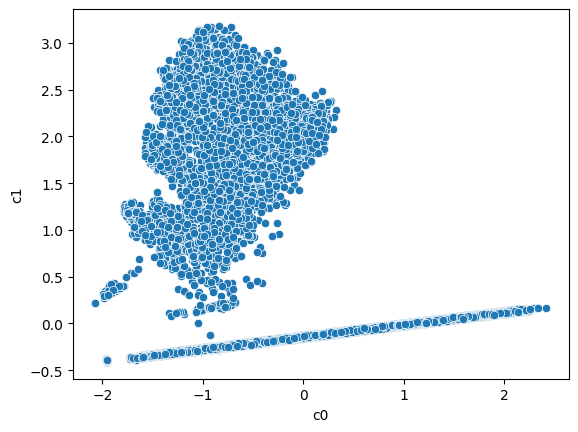

In [6]:
sns.scatterplot(data=train_pca, x="c0", y="c1")
plt.show()

# Clustering

In [7]:
km = KMeans(n_clusters=3, 
            random_state=42,
            max_iter=100,
            init="k-means++", 
            tol=0.0001)
y_km = km.fit_predict(train_pca)
y_km_test = km.predict(test_pca)

In [ ]:
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(y_km)
n_clusters=cluster_labels.shape[0]    

silhouette_vals = silhouette_samples(train_pca, y_km, metric='euclidean')  
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]   
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              
        color = cm.jet(float(i)/n_clusters)              
        plt.barh(range(y_ax_lower,y_ax_upper),            
                         c_silhouette_vals,               
                         height=1.0,                      
                         edgecolor='none',                
                         color=color)                     
        yticks.append((y_ax_lower+y_ax_upper)/2)          
        y_ax_lower += len(c_silhouette_vals)              

silhouette_avg = np.mean(silhouette_vals)                 
plt.axvline(silhouette_avg,color="red",linestyle="--")     
plt.yticks(yticks,cluster_labels + 1)                     
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

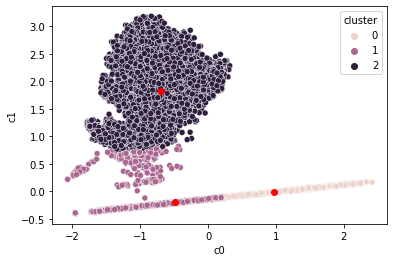

In [9]:
train_pca["cluster"] = y_km
test_pca["cluster"] = y_km_test

center = km.cluster_centers_

sns.scatterplot(data=train_pca, x="c0", y="c1", hue="cluster")
plt.plot(center[0, 0], center[0, 1], "bo", c="r")
plt.plot(center[1, 0], center[1, 1], "bo", c="r")
plt.plot(center[2, 0], center[2, 1], "bo", c="r")

plt.show()

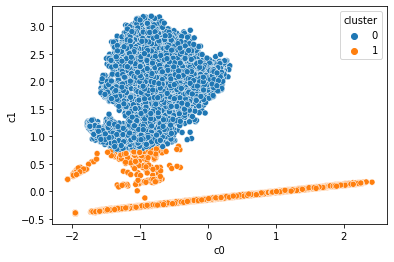

In [10]:

'''
Try to separate the coordinate space that exists in a straight line and 
the cluster that is randomly arranged
'''

train_pca["cluster"] = train_pca.cluster.apply(lambda x: 0 if x == 2 else 1)
test_pca["cluster"] = test_pca.cluster.apply(lambda x: 0 if x == 2 else 1)

sns.scatterplot(data=train_pca, x="c0", y="c1", hue="cluster")
plt.show()

In [11]:

'''
Let's try how it was isolated using the information obtained from the cluster
'''

# merge 
train_pca["breath_id"] = train_pca.index 
train_pca.drop(["c0", "c1"], axis=1, inplace=True)
train_pca = train_pca.reset_index(drop=True)
train = pd.merge(train, train_pca, how="left", on="breath_id")

test_pca["breath_id"] = test_pca.index 
test_pca.drop(["c0", "c1"], axis=1, inplace=True)
test_pca = test_pca.reset_index(drop=True)
test = pd.merge(test, test_pca, how="left", on="breath_id")

# helper 
def find_cluster_r_c(df):
    fig, ax = plt.subplots(2, 2, figsize=(15, 6))
    for c in range(2):
        for r_c in range(2):
            x = df.loc[df.cluster == c, "R" if r_c == 0 else "C" ]
            sns.countplot(x, ax=ax[c][r_c])
            ax[c][r_c].set_title(f"Cluster={c}")
    plt.tight_layout()
    
    
def find_cluster_transition(df, is_train=True):
    fig, ax = plt.subplots(2, 5, figsize=(15, 6))
    for c in range(2):
        x = df.loc[df.cluster == c]
        breath = x.breath_id.unique()
        for n in range(5):
            if is_train:
                xx = x.loc[x.breath_id == breath[n], ["time_step", "u_in", "u_out", "pressure"]]
            else:
                xx = x.loc[x.breath_id == breath[n], ["time_step", "u_in", "u_out"]]
            xx.set_index("time_step").plot(ax=ax[c][n])
            ax[c][n].set_title(f"breath_id={breath[n]}")
            ax[c][n].set_xticks([])
            
            if n == 0:
                ax[c][n].set_ylabel(f"Cluster={c}")
    plt.tight_layout()
            

<AxesSubplot:xlabel='cluster', ylabel='count'>

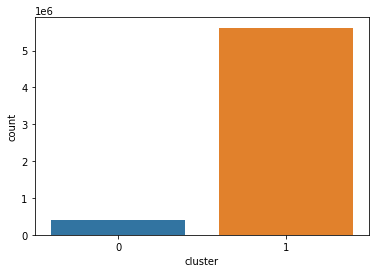

In [12]:
sns.countplot(train.cluster)

<AxesSubplot:xlabel='cluster', ylabel='count'>

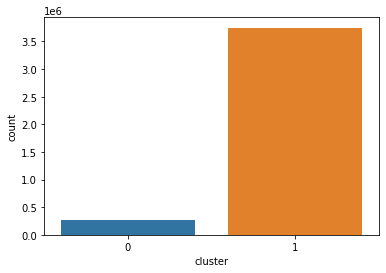

In [13]:
sns.countplot(test.cluster)

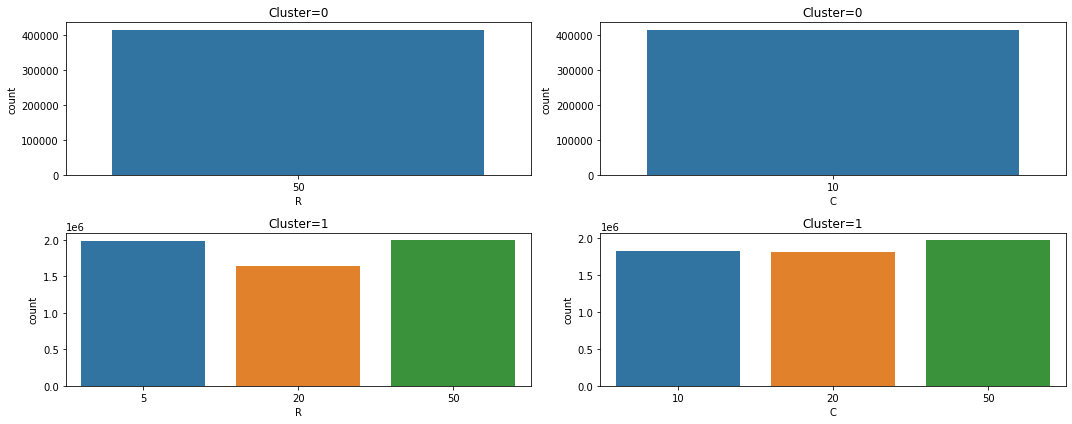

In [14]:

'''
Some clusters show a single attribute.
It is more strongly reflected in clusters that do not exist in a straight line.
'''

find_cluster_r_c(train)

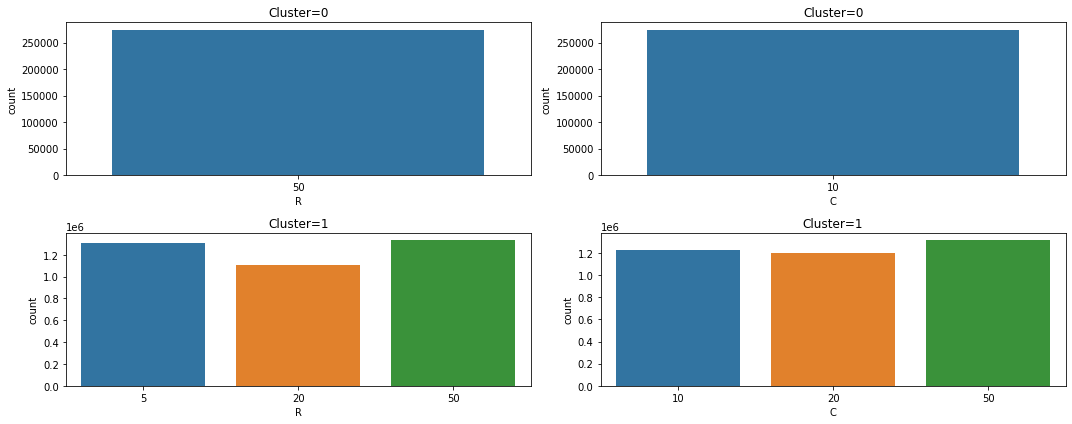

In [15]:
find_cluster_r_c(test)

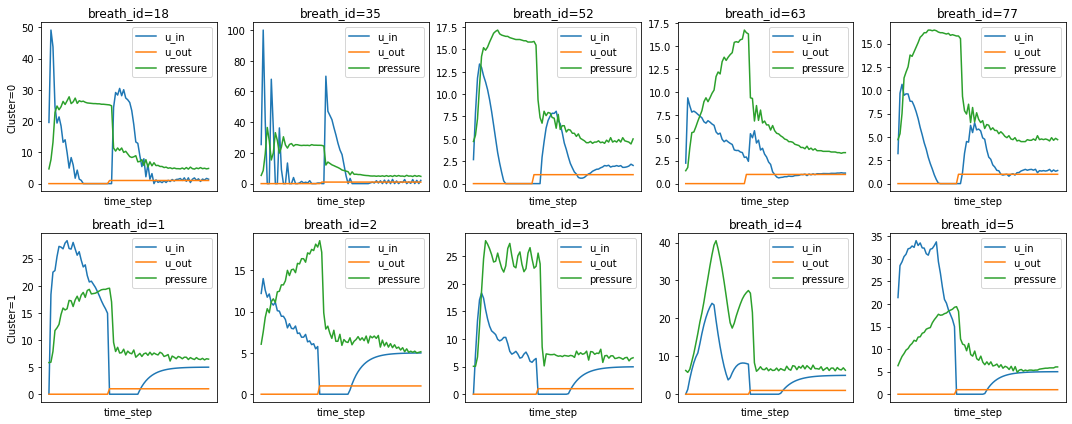

In [16]:

'''
From the time-series data distribution,
we confirmed a sharp rise in u_in following 1.0 second. 
After that, it decreases smoothly.
'''

find_cluster_transition(train)

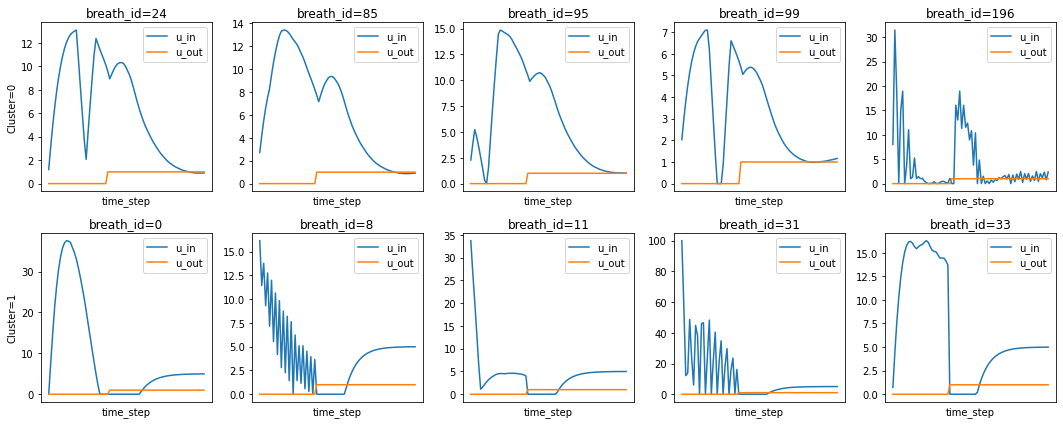

In [17]:
find_cluster_transition(test, False)

In [18]:
train.drop(["time_step_class", "log_u_in"], axis=1, inplace=True)
test.drop(["time_step_class", "log_u_in"], axis=1, inplace=True)

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)